# Predicting Arrests
The main goal of the model was to accurately predict whether an arrest will be made for a crime in the city of Chicago. However, because the best I was able to achieve was only 7% higher than the baseline validation accuracy (predicting no arrest every time), it appears that the current dataset isn't the best for predicting arrests. 

In [49]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')

In [97]:
crimes = pd.read_csv('Data/crimes_cleaned.csv')

In [138]:
#sorting by Date
crimes.sort_values(by='Date', ascending=True, inplace=True)

In [139]:
crimes.head()

,Date,Primary Type,Arrest,Domestic,Year,Location,Location Description,Community Area,Region,2010 Population,Month,Day of Week,Time of Day,Season
2783830,2010-01-01 00:00:00,Crim Sexual Assault,1,True,2010,"(41.871436933, -87.719700102)",Residence,East Garfield Park,West Side,20567.0,1,Friday,Night,Winter
1661264,2010-01-01 00:00:00,Theft,0,False,2010,"(41.806527859, -87.622761468)",Residence,Grand Boulevard,South Side,21929.0,1,Friday,Night,Winter
2378495,2010-01-01 00:00:00,Offense Involving Children,0,False,2010,"(41.709494361, -87.536487549)",Residence,East Side,Far Southeast Side,23042.0,1,Friday,Night,Winter
1273122,2010-01-01 00:00:00,Theft,0,False,2010,"(41.745877762, -87.555213717)",Residence,South Chicago,Far Southeast Side,31198.0,1,Friday,Night,Winter
1652853,2010-01-01 00:00:00,Offense Involving Children,0,False,2010,"(41.765794757, -87.689392862)",Residence,Chicago Lawn,Southwest Side,55628.0,1,Friday,Night,Winter


In [140]:
#only keeping certain columns
crimes_cols = crimes[['Arrest', 'Primary Type', 'Year', 'Month', 'Location Description', 'Time of Day', 'Season']]

In [141]:
crimes_cols.head()

,Arrest,Primary Type,Year,Month,Location Description,Time of Day,Season
2783830,1,Crim Sexual Assault,2010,1,Residence,Night,Winter
1661264,0,Theft,2010,1,Residence,Night,Winter
2378495,0,Offense Involving Children,2010,1,Residence,Night,Winter
1273122,0,Theft,2010,1,Residence,Night,Winter
1652853,0,Offense Involving Children,2010,1,Residence,Night,Winter


<a id="dummy">

## Creating Dummy Variables for the Categorical Features

In [142]:
oh = OneHotEncoder(drop='first', sparse=False)
crimes_dummy = oh.fit_transform(crimes_cols)

In [143]:
print("Number of Rows: {:,d}".format(crimes_dummy.shape[0]))
print("Number of New Columns: {:,d}".format(crimes_dummy.shape[1]))

Number of Rows: 2,924,694
Number of New Columns: 145


## Splitting into Train, Test, and Validation Sets

In [144]:
#splitting into X and y 
y = crimes_dummy[:,0]
X = crimes_dummy[:,1:]

#creating train,validation, and test sets in order, to avoid testing on old data on a model trained on newer data
train_end_idx = int(X.shape[0]*0.70)
val_end_idx = int(X.shape[0]*0.85)

#splitting into train and test sets
X_train = X[:train_end_idx, :]
X_val = X[train_end_idx:val_end_idx, :]
X_test = X[val_end_idx:, :]

y_train = y[:train_end_idx]
y_val = y[train_end_idx:val_end_idx]
y_test = y[val_end_idx:]

## Training Models

### Random Forest

In [170]:
#only selecting a subset of the most recent observations to speed up hyperparameter tuning
obs = 100000

#initializing the model
rf = RandomForestClassifier(n_estimators=1000, max_depth=10 
                            random_state=0, oob_score=True)
rf.fit(X_train[-obs:,:], y_train[-obs:])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [171]:
print("Model Accuracy: {:.3}".format(rf.oob_score_))

Model Accuracy: 0.873


In [172]:
print("Arrest Rate: {:.3f}".format(y_val.mean()))
print("Baseline Validation Accuracy when predicting all 0's: {:.3f}".format(1-y_val.mean()))
print("Model Validation Accuracy: {:.3f}".format(rf.score(X_val, y_val)))

Arrest Rate: 0.194
Baseline Validation Accuracy when predicting all 0's: 0.806
Model Validation Accuracy: 0.877


### Feed Forward Neural Network

In [155]:
model = keras.Sequential([
    keras.layers.Dense(1028, input_dim=X_train.shape[1], activation='relu'),
#     keras.layers.Dense(512, activation='relu'), 
#     keras.layers.Dropout(0.05),
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dropout(0.05),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.05),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')   
])

In [156]:
#printing the model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 1028)              149060    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               263424    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_84 (Dense)             (None, 1)               

In [157]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [158]:
obs = 100000

history = model.fit(X_train[-obs:, :], y_train[-obs:], epochs=10, batch_size=128)

Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 5s 52us/sample - loss: 0.3352 - accuracy: 0.8683
Epoch 2/10
100000/100000 [==============================] - 4s 44us/sample - loss: 0.3191 - accuracy: 0.8758
Epoch 3/10
100000/100000 [==============================] - 4s 44us/sample - loss: 0.3168 - accuracy: 0.8768
Epoch 4/10
100000/100000 [==============================] - 4s 44us/sample - loss: 0.3149 - accuracy: 0.8770
Epoch 5/10
100000/100000 [==============================] - 4s 44us/sample - loss: 0.3131 - accuracy: 0.8778
Epoch 6/10
100000/100000 [==============================] - 4s 44us/sample - loss: 0.3112 - accuracy: 0.8781
Epoch 7/10
100000/100000 [==============================] - 4s 45us/sample - loss: 0.3099 - accuracy: 0.8787
Epoch 8/10
100000/100000 [==============================] - 4s 45us/sample - loss: 0.3083 - accuracy: 0.8789
Epoch 9/10
100000/100000 [==============================] - 4s 45us/sample - loss: 0.3074 - accuracy: 0.

In [165]:
print("Arrest Rate: {:.3f}".format(y_val.mean()))
print("Baseline Validation Accuracy when predicting all 0's: {:.3f}".format(1-y_val.mean()))
print("Model Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=128)[1]))

Arrest Rate: 0.194
Baseline Validation Accuracy when predicting all 0's: 0.806
438704/438704 [==============================] - 7s 17us/sample - loss: 0.3373 - accuracy: 0.8767
Model Validation Accuracy: 0.877


In [160]:
y_pred = model.predict(X_val)

In [161]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

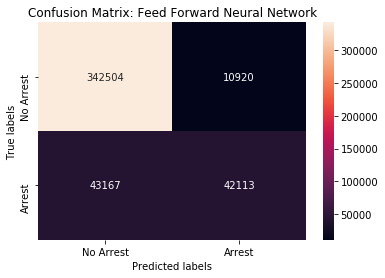

In [162]:
cm = confusion_matrix(y_val, y_pred)  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Feed Forward Neural Network')
ax.xaxis.set_ticklabels(['No Arrest', 'Arrest'])
ax.yaxis.set_ticklabels(['No Arrest', 'Arrest'])

plt.show()